In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch # deep learning
import torchvision # image preprocessing
from PIL import Image # read image
import matplotlib.pyplot as plt # image plotting
import os

In [9]:
# define the image preprocessing transformation
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(p = 0.5)
])


In [10]:
# create datasets
trainset = torchvision.datasets.ImageFolder("dogbreeds/train", transform = transform)
validset = torchvision.datasets.ImageFolder("dogbreeds/valid", transform = transform)
testset = torchvision.datasets.ImageFolder("dogbreeds/test", transform = transform)


In [11]:
# create DataLoaders
batch_size = 64

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [12]:
# double check shapes
data_iter = iter(train_loader) 
images, labels = next(data_iter)
print(images.shape)
print(labels.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])


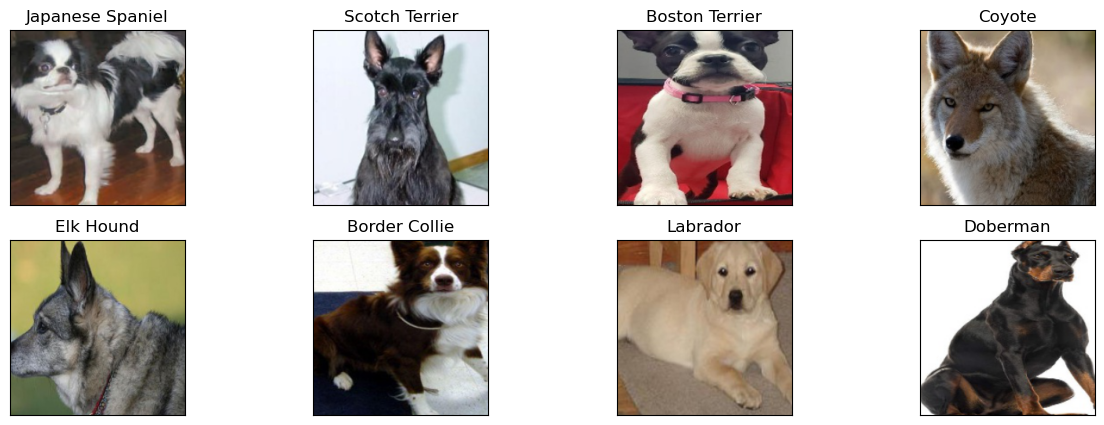

In [13]:
# visualize the data
data_iter = iter(train_loader)
images, labels = next(data_iter)
images, labels = images.numpy() , labels.numpy()

fig = plt.figure(figsize = (15,5))

for i in range(int(batch_size/8)):
    ax = fig.add_subplot(2 , int(batch_size/16) , i + 1 , xticks = [] , yticks = [])
    ax.imshow(np.transpose(images[i] , (1,2,0)) , cmap = 'gray')
    ax.set_title(trainset.classes[labels[i]])


In [20]:
import torch.nn as nn
# import resnet because it turns out that there is not nearly enough data for this task
model = torchvision.models.resnet50(pretrained=True)
for param in model.parameters():
    param = param.requires_grad_(False)
# model
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, len(trainset.classes)),
    nn.LogSoftmax(dim=1)
)


In [21]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
# training + validation
num_epochs = 36
for epoch in range(num_epochs):
    # training
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_loss = running_train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # validation
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")


Epoch 1/36, Train Loss: 1.7077, Train Accuracy: 60.81%
Epoch 1/36, Validation Loss: 0.3869, Validation Accuracy: 92.29%
Epoch 3/36, Train Loss: 0.4573, Train Accuracy: 86.32%
Epoch 3/36, Validation Loss: 0.2128, Validation Accuracy: 95.00%
Epoch 4/36, Train Loss: 0.3934, Train Accuracy: 87.47%
Epoch 4/36, Validation Loss: 0.1942, Validation Accuracy: 94.86%
Epoch 5/36, Train Loss: 0.3386, Train Accuracy: 89.27%
Epoch 5/36, Validation Loss: 0.1989, Validation Accuracy: 93.00%
Epoch 6/36, Train Loss: 0.3220, Train Accuracy: 89.76%
Epoch 6/36, Validation Loss: 0.1726, Validation Accuracy: 94.14%
Epoch 7/36, Train Loss: 0.3059, Train Accuracy: 89.91%
Epoch 7/36, Validation Loss: 0.1871, Validation Accuracy: 93.43%
Epoch 9/36, Train Loss: 0.2596, Train Accuracy: 91.47%
Epoch 9/36, Validation Loss: 0.1551, Validation Accuracy: 95.29%
Epoch 10/36, Train Loss: 0.2470, Train Accuracy: 91.71%
Epoch 10/36, Validation Loss: 0.1514, Validation Accuracy: 95.29%
Epoch 11/36, Train Loss: 0.2272, Train

In [23]:
# save the model
torch.save(model.state_dict(), 'resnetbasemodel.pth')

In [24]:
model.eval()  
running_test_loss = 0.0
all_predictions = []
all_true_values = []

num_samples_to_display = 50
sample_count = 0  

with torch.no_grad(): 
    for batch_idx, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        test_loss = criterion(outputs, labels)
        running_test_loss += test_loss.item()
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())  
        all_true_values.extend(labels.cpu().numpy()) 

        # Display predictions and labels for a few samples
        if sample_count < num_samples_to_display:
            for i in range(len(predicted)):
                if sample_count >= num_samples_to_display:
                    break
                print(f"Sample {sample_count + 1}: Predicted: {predicted[i].item()}, True Label: {labels[i].item()}")
                sample_count += 1


# Average test loss
average_test_loss = running_test_loss / len(test_loader)
print(f"Test Loss after training: {average_test_loss:.4f}")

# Compute accuracy
correct = sum(p == t for p, t in zip(all_predictions, all_true_values))
accuracy = correct / len(all_true_values) * 100
print(f"Test Accuracy: {accuracy:.2f}%")


Sample 1: Predicted: 2, True Label: 2
Sample 2: Predicted: 52, True Label: 52
Sample 3: Predicted: 19, True Label: 19
Sample 4: Predicted: 25, True Label: 25
Sample 5: Predicted: 20, True Label: 20
Sample 6: Predicted: 57, True Label: 57
Sample 7: Predicted: 1, True Label: 1
Sample 8: Predicted: 26, True Label: 26
Sample 9: Predicted: 26, True Label: 26
Sample 10: Predicted: 46, True Label: 46
Sample 11: Predicted: 6, True Label: 6
Sample 12: Predicted: 17, True Label: 17
Sample 13: Predicted: 63, True Label: 63
Sample 14: Predicted: 12, True Label: 12
Sample 15: Predicted: 60, True Label: 60
Sample 16: Predicted: 22, True Label: 22
Sample 17: Predicted: 9, True Label: 9
Sample 18: Predicted: 6, True Label: 6
Sample 19: Predicted: 14, True Label: 14
Sample 20: Predicted: 61, True Label: 61
Sample 21: Predicted: 46, True Label: 46
Sample 22: Predicted: 52, True Label: 52
Sample 23: Predicted: 17, True Label: 17
Sample 24: Predicted: 0, True Label: 0
Sample 25: Predicted: 3, True Label: 